In [1]:
import sys

import numpy as np

sys.path.insert(1, "./src")

In [2]:
import pickle
from pathlib import Path

import yaml
from transformers import set_seed

from anonymization.gpt2_generation import GPT2GenerationAnonymization
from mask.util import convert_masked_docs_to_segments_set
from models.gpt2_model import PretrainedGPT2TextInfilling
from utils.infill_metrics import Statistics
from utils.log_reader import TensorBoardReader
from datasets.ner_dataset import get_ner_dataset
from mask.personal_entity import MaskEntityType

In [3]:
set_seed(42)

In [4]:
mask_config = yaml.load(open("configs/ngram_mask_config.yaml", 'r'), Loader=yaml.Loader)
roc_stories_data_config = yaml.load(open("configs/roc_stories_data_config.yaml", 'r'), Loader=yaml.Loader)
i2b2_2006_data_config = yaml.load(open("configs/i2b2-2006_data_config.yaml", 'r'), Loader=yaml.Loader)
i2b2_2014_data_config = yaml.load(open("configs/i2b2-2014_data_config.yaml", 'r'), Loader=yaml.Loader)

In [5]:
# Anonymization config initialisation
anon_gpt2_config = yaml.load(open("configs/gpt2_anonymization_config.yaml", 'r'), Loader=yaml.Loader)

In [6]:
# Инициализация алгоритма генерации искусственных сущностей с помощью GPT2
model_reader = TensorBoardReader(Path(anon_gpt2_config["log_dir"]) / Path("lightning_logs"))
path_to_checkpoint = model_reader.get_ckpt_path(anon_gpt2_config["model_version"])
text_infill_model = PretrainedGPT2TextInfilling.load_from_checkpoint(path_to_checkpoint, strict=False).to("cuda:0")

anonymization = GPT2GenerationAnonymization(text_infill_model,
                                            label2type=lambda x: MaskEntityType[x.upper()],
                                            mask_types=list(MaskEntityType), **anon_gpt2_config)

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:188: Found keys that are not in the model state dict but in the checkpoint: ['ner_model.model.embeddings.word_embeddings.weight', 'ner_model.model.embeddings.position_embeddings.weight', 'ner_model.model.embeddings.token_type_embeddings.weight', 'ner_model.model.embeddings.LayerNorm.weight', 'ner_model.model.embeddings.LayerNorm.bias', 'ner_model.model.encoder.layer.0.attention.self.query.weight', 'ner_model.model.encoder.layer.0.attention.self.query.bias', 'ner_model.model.encoder.layer.0.attention.self.key.weight', 'ner_model.model.encoder.layer.0.attention.self.key.bias', 'ner_model.model.encoder.layer.0.attention.self.value.weight', 'ner_model.model.encoder.layer.0.attention.self.value.bias', 'ner_model.model.encoder.layer.0.attention.output.dense.weight', 'ner_model.model.encoder.layer.0.attention.output.dense.bias', 'ner_model.model.encoder.layer.0.attention.output.LayerNorm.weight', 'ne

### Графики обучения модели для заполнения пропусков

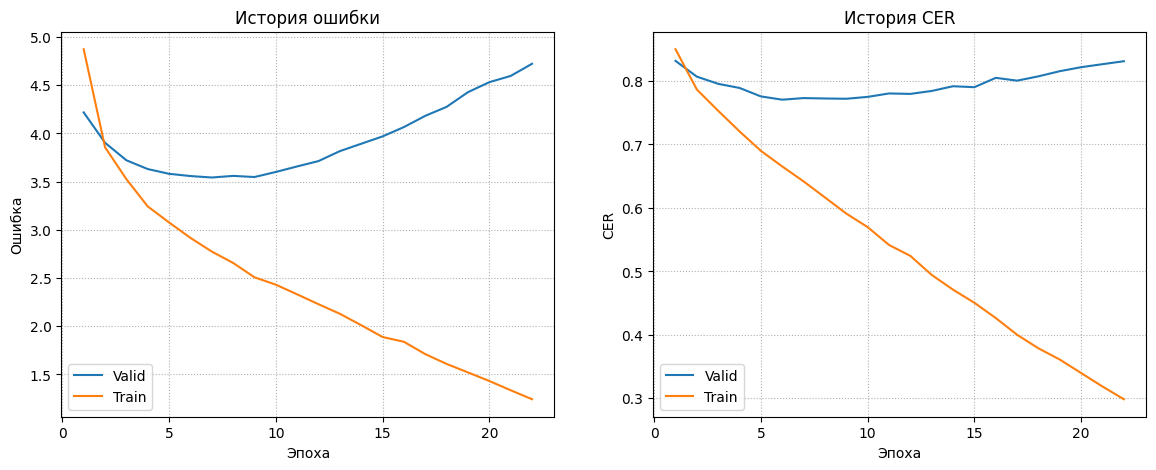

In [7]:
model_reader.plot_text_infill_tensorboard_graphics()

#### Проверка заполнения пропусков на случайным образом замаскированных текстах (roc stories)

In [8]:
path_to_data = roc_stories_data_config["validate_data_path"]
split = "valid"
if Path(path_to_data).suffix != '.pkl':
    path_to_data = str(Path(path_to_data).parent / Path(f'{Path(path_to_data).stem}_{split}.pkl'))
    
# категории сущностей в формате [список категорий отрезков в документе, ...]; исходный текст в формате [список отрезков в документе, ...]
with open(path_to_data, 'rb') as f:
    # [(текст документа, список наборов масок для него: [[(тип, сдвиг, длина), ...], ...]), ...]
    infill_dataset = pickle.load(f)
    _, categories_list, source_texts = convert_masked_docs_to_segments_set(infill_dataset)

In [9]:
infill_stats = Statistics(anonymization, categories_list[:3000], categories_list[:3000], source_texts[:3000], is_uncased=True)

Start data tokenization


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [02:25<00:00,  1.86s/it]


In [10]:
indexes = infill_stats.random_examples_indexes(30)
infill_stats.print_examples_by_indexes(indexes[-5:], max_example_len=500, start_other_len=100)

_____ Record 1149 _____
| Labels:           | O                                         | ID      | O                                           | DATE          | O            | LOCATION      | O                             | DATE             | O                    | LOCATION        |
| Source text:      | Kelly hasn't left her apartment in years. | I went  | up to her place today to say hello. I could | tell she was  | reluctant to | let me in     | . We talked for a while about | how she's doing. | Kelly is agoraphobic | .               |
| Substituted text: | Kelly hasn't left her apartment in years. | 6-11-77 | up to her place today to say hello. I could | june 13, 2077 | reluctant to | june 13, 2077 | . We talked for a while about | june 13, 2077    | Kelly is agoraphobic | ,          9/77 |
| CER               |                                           | 1.167   |                                             | 0.917         |              | 1.222         |                         

#### Проверка заполнения пропусков в примерах с личной информацией (i2b2_2014)

In [11]:
# Для кэширования данных
get_ner_dataset(path_to_folder=i2b2_2014_data_config["validate_data_path"], device='cpu', **i2b2_2014_data_config)

Token indices sequence length is longer than the specified maximum sequence length for this model (1234 > 512). Running this sequence through the model will result in indexing errors


In [12]:
path = str(Path(i2b2_2014_data_config["validate_data_path"]).with_suffix(".pkl"))
with open(path, 'rb') as f:
    (_, source_texts, specific_category_list, general_category_list, _) = pickle.load(f)

In [13]:
infill_stats = Statistics(anonymization, general_category_list, specific_category_list, source_texts, is_uncased=True)

Start data tokenization


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 184/184 [04:50<00:00,  1.58s/it]


In [14]:
indexes = infill_stats.random_examples_indexes(5)
infill_stats.print_examples_by_indexes(indexes[-5:], max_example_len=500, start_other_len=100)

_____ Record 429 _____
| Labels:           | O            | DATE       | O                                                                                                            | DATE     | O                                                                                                              | DATE     | O                   | DATE  | O                                                                                                                                                   | DATE       | O                                                        |
| Source text:      | record date: | 2094-07-28 | reason for visit  comprehensive evaluation and follow-up of problems.    problems        shortness of breath | 11/93    | after starting atenolol (and wt gain) devel doe w/o wheezing. resolved off it (and w inc lasix 60 --> 80). ett | 12/93    | neg to 7 mets, echo | 12/93 | mild/mod mr, ao scle w/o sten, lv mild dil 55, la mod dil,  ef 72%, no rwma, mod sym lvh, all c/w diast

In [15]:
(record_ids, col_j), cer = infill_stats.find_closest_substitutions(5)
print(f"Минимальный CER между изначальным текстом и ответом: {min(cer):.3f}")

Минимальный CER между изначальным текстом и ответом: 0.000


In [16]:
infill_stats.print_examples_by_indexes(record_ids.tolist(), max_example_len=500, start_other_len=100)

_____ Record 213 _____
| Labels:           | O            | DATE       | O          | LOCATION                | O | NAME      | O    | AGE   | O                                                       | DATE  | O                                                 | DATE  | O                                                                                                                  | DATE  | O                                                                                                                             |
| Source text:      | record date: | 2082-10-22 | cardiology | griffin nursing center  | reason for visit:        	interval history:    mr.   | xayavong  | is a | 61    | -year-old gentleman with history of cad, anterior stemi | 2077  | , stents x 2 to lad, four stents since then, last | 2080  | , diabetes, chf, unknown ef with ef of 25%, and hypertension currently under pre cardiac transplant evaluation. in | 5/82  | he had biv icd placement as well as left heart catheteri

In [17]:
print("Число идеальных угадываний:", len([x for x in infill_stats.error_rates if any(np.array(x) == 0.)]))

Число идеальных угадываний: 26


#### Проверка заполнения пропусков в примерах с личной информацией (i2b2_2006)

In [18]:
# Для кэширования данных
get_ner_dataset(path_to_folder=i2b2_2006_data_config["validate_data_path"], device='cpu', **i2b2_2006_data_config)

Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors


In [19]:
path = str(Path(i2b2_2006_data_config["validate_data_path"]).with_suffix(".pkl"))
with open(path, 'rb') as f:
    (_, source_texts, specific_category_list, general_category_list, _) = pickle.load(f)

In [20]:
infill_stats = Statistics(anonymization, general_category_list, specific_category_list, source_texts, is_uncased=True)

Start data tokenization


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [02:00<00:00,  1.74s/it]


In [21]:
indexes = infill_stats.random_examples_indexes(5)
infill_stats.print_examples_by_indexes(indexes[-5:], max_example_len=500, start_other_len=100)

_____ Record 194 _____
| Labels:           | O | ID        | O | LOCATION | O | ID       | O | ID      | O | DATE    | O                                                  | DATE  | O                                      | DATE  | O                                    | NAME              | O | ID              | O      | LOCATION               | O                                    | DATE  | O                                                                                                                    | NAME             | O                                                                                     |
| Source text:      |   | 275500876 |   | elmvh    |   | 70589933 |   | 3136676 |   | 2/23    | /2004 12:00:00 am s / p rltcs dis admission date : | 02/23 | /2004 report status : discharge date : | 02/27 | /2004 ****** discharge orders ****** | subesligh , sharo |   | 890-85-13-5 n57 | room : | drain general hospital | service : obs discharge patient on : | 02/27 | /04 at 10:00 am

In [22]:
(record_ids, col_j), cer = infill_stats.find_closest_substitutions(5)
print(f"Минимальный CER между изначальным текстом и ответом: {min(cer):.3f}")

Минимальный CER между изначальным текстом и ответом: 0.000


In [23]:
infill_stats.print_examples_by_indexes(record_ids.tolist(), max_example_len=500, start_other_len=100)

_____ Record 131 _____
| Labels:           | O | ID        | O | LOCATION        | O | ID      | O | ID      | O | ID      | O | DATE  | O                                                                                                  | NAME           | O             | ID        | O                | DATE  | O                      | DATE  | O                                                                                                                                                                                                                                                                              |
| Source text:      |   | 237073320 |   | fih             |   | 9746390 |   | 797120  |   | 251605  |   | 01/26 | /1998 12:00:00 am discharge summary unsigned dis report status : unsigned discharge summary name : | shuff , ronhum | unit number : | 172-00-89 | admission date : | 01/26 | /1998 discharge date : | 02/22 | /1998 principal diagnosis : acute inferior wall myocardial infar

In [24]:
print("Число идеальных угадываний:", len([x for x in infill_stats.error_rates if any(np.array(x) == 0.)]))

Число идеальных угадываний: 5
